# GP emulation of multivariate GlaDS ensemble

This notebook explores emulating multivariate GlaDS outputs. To maintain fast sampling and prediction, we consider spatially averaged, daily flotation fraction timeseries. Just as with full spatiotemporal fields, we handle the multivariate outputs using a principal component representation.

In [ ]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import cmocean

from sepia.SepiaData import SepiaData
from sepia.SepiaModel import SepiaModel
from sepia.SepiaPredict import SepiaEmulatorPrediction

## 1 GlaDS ensemble

Read in the data and plot the timeseries to get a sense of what the ensemble looks like.

In [163]:
m = 128

X_phys = np.loadtxt('./data/GlaDS_example/synthetic_train_physical.csv',
    delimiter=',', skiprows=1)[:m]
X_std = np.loadtxt('./data/GlaDS_example/synthetic_train_standard.csv',
    delimiter=',', skiprows=1)[:m]
X_names = np.loadtxt('./data/GlaDS_example/synthetic_train_standard.csv',
    delimiter=',', max_rows=1, dtype=str)

Y_phys = np.load('./data/GlaDS_example/synthetic_ff_timeseries.npy')[:m]

# Standardize the Y data
mu_y = np.mean(Y_phys, axis=0)
sd_y = np.std(Y_phys, axis=0)
Y = (Y_phys - mu_y)/sd_y

# Note that the mean and sd are vectors now
print(mu_y.shape)

(365,)


We can visualize the ensemble by lightly plotting each member and overlaying the average. Note the average here is exactly what's used to center the simulation outputs. We can see there is lots of variance between ensemble members, especially in the spring. Between days 150--200, flotation fraction variances from $<1$ to $>2$. There is much less variation in winter, with the range mostly between 0.5 and 0.85.

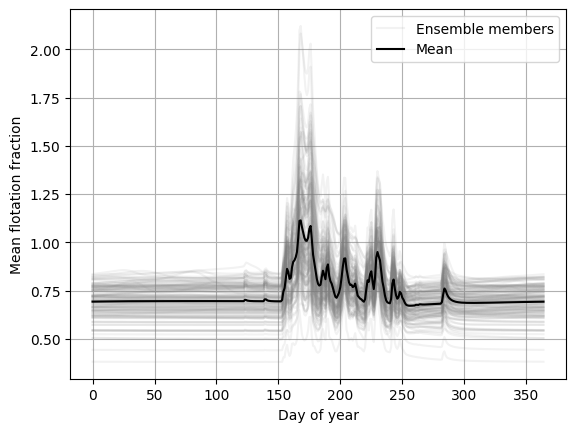

In [180]:
fig, ax = plt.subplots()
lines = ax.plot(np.arange(365), Y_phys.T, color='gray', alpha=0.1, label='Ensemble members')
mean_line = ax.plot(mu_y, color='k', label='Mean')
ax.set_ylabel('Mean flotation fraction')
ax.set_xlabel('Day of year')
ax.legend(handles=[lines[0], mean_line[0]])
ax.grid()

## 2 Principal components

To handle these multivariate outputs, where each simulation produces 365 values (i.e., daily flotation fraction), we use a principal component decomposition. This ensemble is small enough to use exact singular value decomposition from `scipy.linalg`. Here, we use an arbitrary variance threshold to select the number of principal components. Ideally, this should be done by comparing prediction error for models with varying numbers of PCs, including inspecting errors for individual simulations. It's possible to explain a reasonable proportion of the variance (e.g., 99%) but have low-rank representations that are missing essential features of the original data. In short, choose the number of PCs more carefully than is done here.

(128, 128)
(128,)
(128, 365)
6 PCs explains at least 99.0% of variance


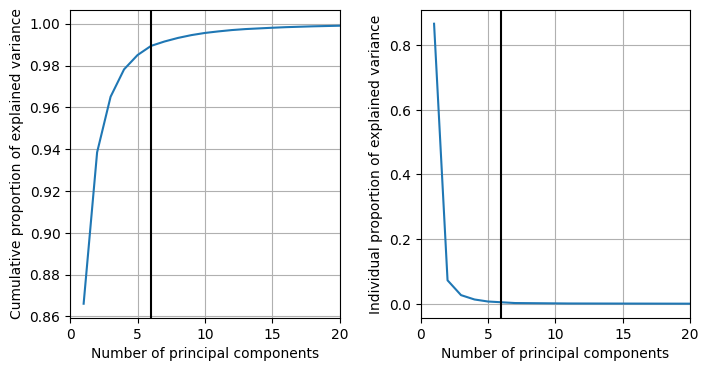

In [182]:
U,S,V = scipy.linalg.svd(Y, full_matrices=False)

print(U.shape)
print(S.shape)
print(V.shape)

percent_var = S**2/np.sum(S**2)
cumul_percent_var = np.cumsum(percent_var)

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8, 4))
ax1.plot(np.arange(1, m+1), cumul_percent_var)
ax1.set_xlabel('Number of principal components')
ax1.set_ylabel('Cumulative proportion of explained variance')
ax1.grid()
ax1.set_xlim([0, 20])

ax2.plot(np.arange(1, m+1), percent_var)
ax2.set_xlabel('Number of principal components')
ax2.set_ylabel('Individual proportion of explained variance')
ax2.grid()
ax2.set_xlim([0, 20])

# Find an appropriate number of PCs based on a variance threshold
var_threshold = 0.99
p = np.min(np.where(cumul_percent_var>=var_threshold)[0])
print('{} PCs explains at least {:.1%} of variance'.format(p, var_threshold))

ax1.axvline(p, color='k')
ax2.axvline(p, color='k')

fig.subplots_adjust(wspace=0.3)

(6, 365)


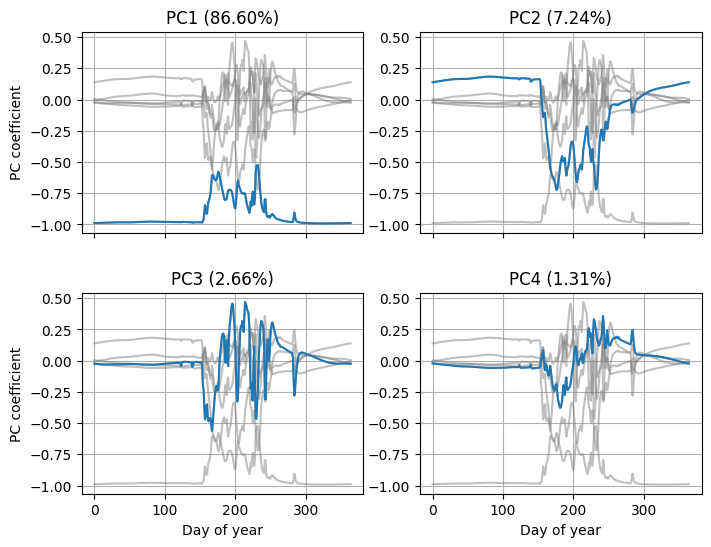

In [183]:
# Define the basis and explore
K = np.diag(S[:p]) @ V[:p] / np.sqrt(m)
print(K.shape)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)

for i in range(4):
    axs.flat[i].plot(np.arange(365), K.T, color='gray', alpha=0.5)
    axs.flat[i].plot(np.arange(365), K[i])
    axs.flat[i].grid()
    axs.flat[i].set_title('PC{} ({:.2%})'.format(i+1, percent_var[i]))

fig.subplots_adjust(hspace=0.3)

for ax in axs[-1,:]:
    ax.set_xlabel('Day of year')

for ax in axs[:, 0]:
    ax.set_ylabel('PC coefficient')

This figure gives a nice interpretation of the PCs. PC1 looks like it mainly controls winter values, with weaker influence on summer. PC2 controls the contrast between summer and winter water pressure. PC 3, 4 and later PCs are more difficult to interpret since they change sign through the summer.

## 3 Multivariate GP emulator

We now have all the pieces to fit the multivariate GP emulator. This is essentially a combination of $p=6$ independent univariate GP emulators, corresponding to the principal component values. This is easy using `SEPIA`, we just specify the basis as the matrix `K`. We will encounter another modification later when extracting emulator predictions.

In [184]:
# Initialize the model instance using our X,Y data
data = SepiaData(t_sim=X_std, y_sim=Y_phys, y_ind_sim=np.arange(Y_phys.shape[1]))
data.standardize_y(y_mean=mu_y, y_sd=sd_y)
ninputs = X_std.shape[1]
data.transform_xt(t_notrans=np.arange(ninputs))

# New for multivariate GP: set the basis
data.create_K_basis(K=K.astype(np.float32))
print(data)

model = SepiaModel(data)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 365
m  =   128 (number of simulated data)
p  =     1 (number of inputs)
q  =     8 (number of additional simulation inputs)
pu =     6 (transformed response dimension)



The steps to sample from the emulator are the same as for a univariate GP, but sampling takes a little longer

In [187]:
# Tune step sizes to improve MCMC efficiency
model.tune_step_sizes(100, 5)

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1]]
lamUz
[[5. 5. 5. 5. 5. 5.]]
lamWs
[[100. 100. 100. 100. 100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.29it/s]

Done with tune_step_size.
Selected step sizes:
betaU
[[0.21807901 0.35938284 0.63096484 0.43737468 0.98539625 0.13144971]
 [0.1685288  0.45121185 0.32104423 0.43933641 0.63880955 0.51472865]
 [0.0498885  0.37244232 0.53772694 0.64792937 0.40663573 0.6393852 ]
 [0.10823595 0.26785777 0.08578644 0.46809005 0.3141313  0.47998723]
 [0.15488645 0.42214862 0.41151519 0.5611491  0.60405658 0.5662189 ]
 [0.00556952 0.21965345 0.20265345 0.22228007 0.28125089 0.28997769]
 [0.08605513 0.06579886 0.1681878  0.5472387  0.20047905 0.15363517]
 [0.00674507 0.04648224 0.02320299 0.28785927 0.20058475 0.2299706 ]
 [0.01350746 0.14099287 0.50621751 0.55067763 0.63529355 0.49690732]]
lamUz
[[0.19738913 0.69557026 0.23447102 0.41286624 0.72901824 0.34817501]]
lamWs
[[ 1241.49501607  1361.23295682  2405.29325129  2122.38359221
  22543.46511175  4580.58878343]]
lamWOs
[[7.65411919]]


In [188]:
# Do the MCMC, draw lots of samples
model.do_mcmc(512)

MCMC sampling: 100%|██████████████████████████████████████████████████████████████████| 512/512 [00:40<00:00, 12.67it/s]


### Evaluate the MCMC samples
We need to make sure that the MCMC has done a good job sampling the distributions. We do this by looking at trace plots.

(512, 54)
(512, 9, 6)


Text(0.5, 1.0, '$\\lambda^{WOs}$ (Simulation precision)')

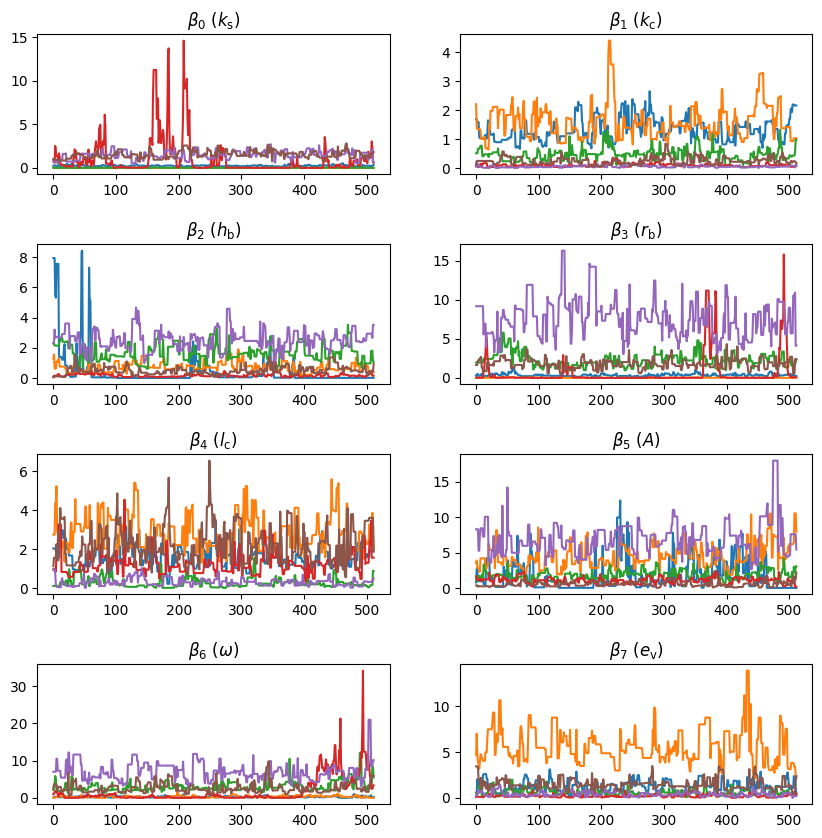

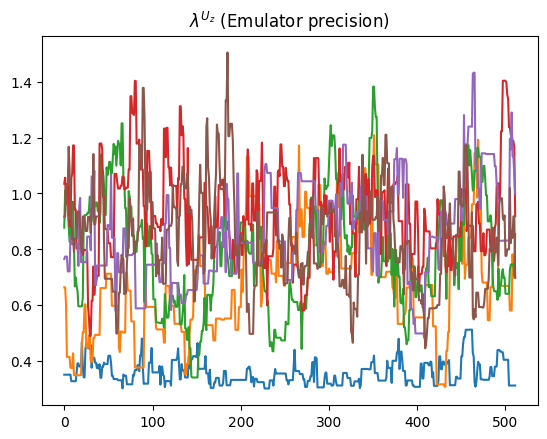

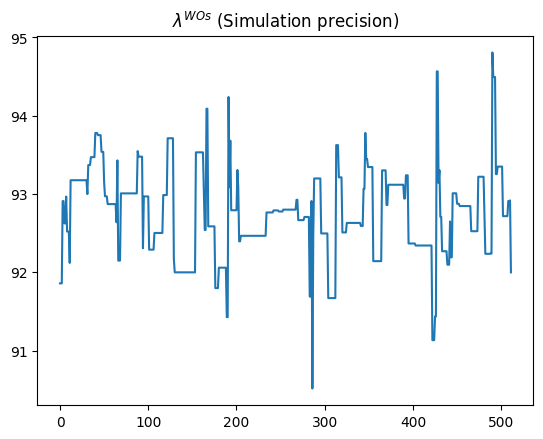

In [189]:
# Look at the MCMC samples to assess their quality
samples = model.get_samples()

beta = samples['betaU']
print(beta.shape)
beta = beta.reshape(beta.shape[0], ninputs+1, p)
print(beta.shape)
beta = beta[:, 1:, :]

fig,axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))
for i in range(ninputs):
    axs.flat[i].plot(beta[:, i, :])
    axs.flat[i].set_title(r'$\beta_{}$ ({})'.format(i, X_names[i]))

fig.subplots_adjust(hspace=0.5)

fig,ax = plt.subplots()
ax.plot(samples['lamUz'])
ax.set_title(r'$\lambda^{U_z}$ (Emulator precision)')

fig,ax = plt.subplots()
ax.plot(samples['lamWOs'])
ax.set_title(r'$\lambda^{WOs}$ (Simulation precision)')

Note that each GP hyperparameter is now associated with $p$ different univariate GPs, corresponding to each of the $p$ PCs. The traces once again look acceptable, with the exception of certain input/PC combinations. These likely represent PCs which are not influenced by the poorly sampled parameters. In particular, we can see the simulator precision, $\lambda^{WO_s}$, has an average near 93, meaning the additional prediction standard deviation (in the normalized space) introduced by the truncated PC basis is about 0.1.

### Emulator predictions

In [191]:
# Read in the test data and test input settings
X_test_phys = np.loadtxt('./data/GlaDS_example/synthetic_test_physical.csv',
    delimiter=',', skiprows=1)[:m]
X_test_std = np.loadtxt('./data/GlaDS_example/synthetic_test_standard.csv',
    delimiter=',', skiprows=1)[:m]

Y_test = np.load('./data/GlaDS_example/test_timeseries.npy')

# Make emulator predictions using a subset of these samples
post_samples = model.get_samples(numsamples=128, nburn=256)

emulator_preds = SepiaEmulatorPrediction(t_pred=X_test_std, 
    samples=post_samples, model=model)

# These are just predictions of the emulator part of the model
# We will also have to sample the error term
y_preds = emulator_preds.get_y()

e_samples = np.zeros(y_preds.shape)
for i in range(e_samples.shape[0]):
    e_samples[i] = sd_y/np.sqrt(post_samples['lamWOs'][i]) * np.random.normal()
    
# Compute mean and quantiles of prediction
y_pred_mean = np.mean(y_preds, axis=0)
y_pred_lq = np.quantile(y_preds + e_samples, 0.025, axis=0)
y_pred_uq = np.quantile(y_preds + e_samples, 0.975, axis=0)

(100,)
(100,)


(0.0, 10.0)

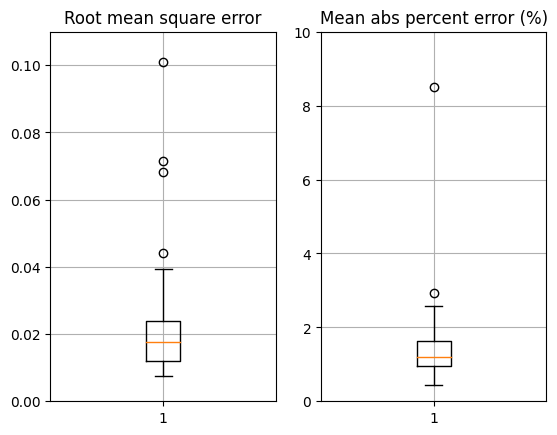

In [192]:
pred_error = y_pred_mean - Y_test
pred_rmse = np.sqrt(np.mean(pred_error**2, axis=1))
pred_mape = np.mean(np.abs(pred_error/Y_test), axis=1)
print(pred_rmse.shape)
print(pred_mape.shape)

fig, axs = plt.subplots(ncols=2)
axs[0].boxplot(pred_rmse)
axs[0].set_title('Root mean square error')
axs[0].grid()
axs[0].set_ylim([0, 0.11])

axs[1].boxplot(100*pred_mape)
axs[1].set_title('Mean abs percent error (%)')
axs[1].grid()
axs[1].set_ylim([0, 10])


We can gain more intuition for how the emulator is performing by considering individual simulations. Here we pick simulations to compare the prediction + uncertainty to the held-out GlaDS test simulations.

[ 81  90 121]
(128, 365)
(100, 365)


Text(0.5, 0, 'Day of year')

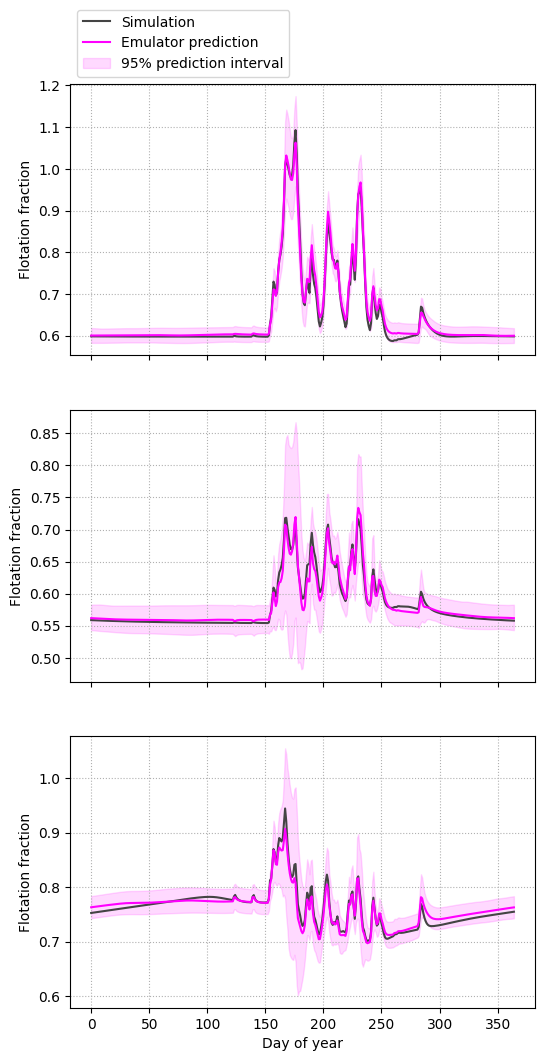

In [193]:
rand_inds = np.random.randint(m, size=3)

print(rand_inds)
print(Y_phys.shape)
print(y_pred_mean.shape)

fig, axs = plt.subplots(nrows=3, figsize=(6, 12), sharex=True)
for i in range(len(rand_inds)):
    axs[i].plot(np.arange(365), Y_test[i], color='#444444', label='Simulation')
    axs[i].plot(np.arange(365), y_pred_mean[i], color='#ff00ff', label='Emulator prediction')
    axs[i].fill_between(np.arange(365), y_pred_lq[i], y_pred_uq[i],
        color='#ff00ff', label='95% prediction interval', alpha=0.15, zorder=0)
    axs[i].grid(linestyle=':')
    axs[i].set_ylabel('Flotation fraction')

axs[0].legend(bbox_to_anchor=(0, 1, 1, 0.4), loc='lower left', frameon=True)
axs[-1].set_xlabel('Day of year')

The emulator predictions, using just 5 PCs, reasonably capture the essential features of the GlaDS simulations. Some of the summer fluctuations have slight differences in the mean or amplitude, but the seasonal variations are captured. The predictions should improve by adding simulations (we have only used 64 of the 512 ensemble!) and might improve by adding more PCs. The 95% prediction interval covers most simulation values, indicating the emulator appropriately estimates its own uncertainty.

## 4 Summary

This workflow is relatively general, and should be extendable to most multivariate model outputs. The GP mean predictions and associated prediction uncertainty should reasonably capture the main features of the simulation data, assuming you have enough simulations and have selected an appropriate number of PCs.

For models that output very large fields (i.e., $\mathcal{O}(10^6)$ values), the sampling and prediction noticably slows down, and some optimization is necessary to moderate memory usage. It can also be challenging to infer the simulation precision, $\lambda^{WO_s}$, representing the PC truncation error, for these large fields. The prior is a Gamma distribution, with parameters determined from the PC truncation error. For large fields, the prior approaches a delta function, so it may be necessary to hold the shape parameter fixed and compute the rate parameter so that the distribution is more appropriately scaled.